In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
# !wget --no-check-certificate \
#     https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
#     -O /tmp/daily-min-temperatures.csv

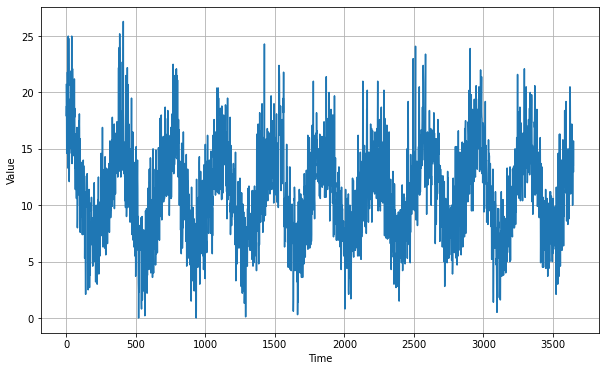

In [3]:
import csv
time_step = []
temps = []
file_path = "../../data/course_4/daily-min-temperatures.csv"
with open(file_path) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step=0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 1s 58ms/step - loss: 25.9814 - mae: 26.4814 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 1s 57ms/step - loss: 25.9042 - mae: 26.4042 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 1s 56ms/step - loss: 25.7858 - mae: 26.2858 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 1s 56ms/step - loss: 25.6412 - mae: 26.1412 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 1s 55ms/step - loss: 25.4750 - mae: 25.9750 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 1s 57ms/step - loss: 25.2866 - mae: 25.7866 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 1s 56ms/step - loss: 25.0756 - mae: 25.5755 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 1s 56ms/step - loss: 24.8395 - mae: 25.3394 - l

10/10 [==============================] - 1s 74ms/step - loss: 1.7303 - mae: 2.1806 - lr: 3.5481e-05
Epoch 73/100
10/10 [==============================] - 1s 63ms/step - loss: 1.7242 - mae: 2.1744 - lr: 3.9811e-05
Epoch 74/100
10/10 [==============================] - 1s 62ms/step - loss: 1.7177 - mae: 2.1673 - lr: 4.4668e-05
Epoch 75/100
10/10 [==============================] - 1s 60ms/step - loss: 1.7126 - mae: 2.1618 - lr: 5.0119e-05
Epoch 76/100
10/10 [==============================] - 1s 59ms/step - loss: 1.7057 - mae: 2.1546 - lr: 5.6234e-05
Epoch 77/100
10/10 [==============================] - 1s 57ms/step - loss: 1.6997 - mae: 2.1483 - lr: 6.3096e-05
Epoch 78/100
10/10 [==============================] - 1s 57ms/step - loss: 1.6932 - mae: 2.1416 - lr: 7.0795e-05
Epoch 79/100
10/10 [==============================] - 1s 56ms/step - loss: 1.6899 - mae: 2.1385 - lr: 7.9433e-05
Epoch 80/100
10/10 [==============================] - 1s 57ms/step - loss: 1.6814 - mae: 2.1300 - lr: 8.9125e

(1e-08, 0.0001, 0.0, 60.0)

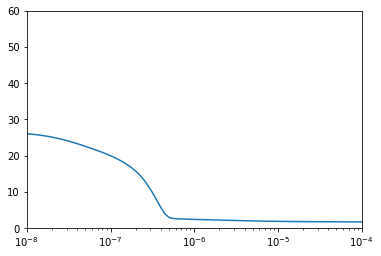

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/100
25/25 [==============================] - 1s 48ms/step - loss: 13.1327 - mae: 13.6177
Epoch 2/100
25/25 [==============================] - 1s 41ms/step - loss: 2.1381 - mae: 2.5962
Epoch 3/100
25/25 [==============================] - 1s 41ms/step - loss: 1.8097 - mae: 2.2614
Epoch 4/100
25/25 [==============================] - 1s 41ms/step - loss: 1.7257 - mae: 2.1746
Epoch 5/100
25/25 [==============================] - 1s 40ms/step - loss: 1.6920 - mae: 2.1400
Epoch 6/100
25/25 [==============================] - 1s 41ms/step - loss: 1.6727 - mae: 2.1206
Epoch 7/100
25/25 [==============================] - 1s 40ms/step - loss: 1.6530 - mae: 2.0999
Epoch 8/100
25/25 [==============================] - 1s 40ms/step - loss: 1.6362 - mae: 2.0827
Epoch 9/100
25/25 [==============================] - 1s 40ms/step - loss: 1.6296 - mae: 2.0758
Epoch 10/100
25/25 [==============================] - 1s 40ms/step - loss: 1.6194 - mae: 2.0649
Epoch 11/100
25/25 [===========================

25/25 [==============================] - 1s 42ms/step - loss: 1.4926 - mae: 1.9316
Epoch 87/100
25/25 [==============================] - 1s 41ms/step - loss: 1.4964 - mae: 1.9358
Epoch 88/100
25/25 [==============================] - 1s 41ms/step - loss: 1.4933 - mae: 1.9325
Epoch 89/100
25/25 [==============================] - 1s 40ms/step - loss: 1.5047 - mae: 1.9447
Epoch 90/100
25/25 [==============================] - 1s 40ms/step - loss: 1.4987 - mae: 1.9381
Epoch 91/100
25/25 [==============================] - 1s 40ms/step - loss: 1.4914 - mae: 1.9302
Epoch 92/100
25/25 [==============================] - 1s 40ms/step - loss: 1.4930 - mae: 1.9322
Epoch 93/100
25/25 [==============================] - 1s 41ms/step - loss: 1.4901 - mae: 1.9291
Epoch 94/100
25/25 [==============================] - 1s 41ms/step - loss: 1.4890 - mae: 1.9282
Epoch 95/100
25/25 [==============================] - 1s 44ms/step - loss: 1.4915 - mae: 1.9306
Epoch 96/100
25/25 [==============================] -

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

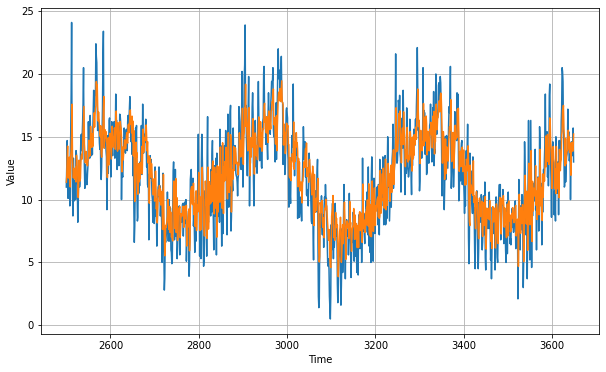

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.8172985

In [14]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.385301  11.806008  13.445976  ... 13.853994  13.8908205 15.2180195]
